<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

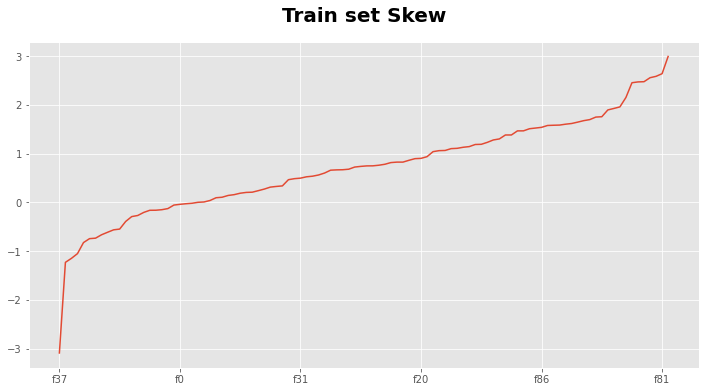

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

In [4]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [6]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

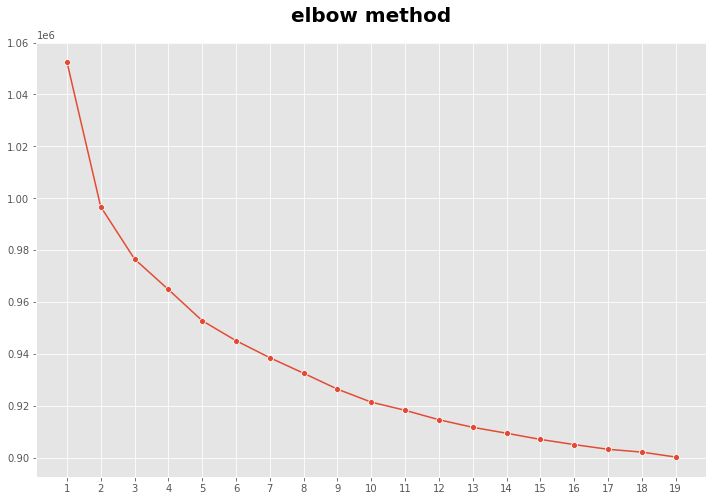

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [46]:
params = {'objective':'poisson', 'metric': 'rmse' } #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-17 09:42:37,640] A new study created in memory with name: no-name-ba7185ec-30d1-491a-be13-575eca4cd114
min_data_in_leaf, val_score: 7.871976: 100%|##########| 5/5 [01:10<00:00, 14.08s/it]


{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 8.755102929703258e-05,
 'lambda_l2': 0.05108148686084268,
 'metric': 'rmse',
 'min_child_samples': 100,
 'num_leaves': 73,
 'objective': 'poisson'}

In [47]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 80000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



KeyboardInterrupt: ignored

# XGBoost LB: 

In [34]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'objective' : 'reg:tweedie',
        'tree_method' : 'gpu_hist',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [35]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-17 09:15:48,863] A new study created in memory with name: no-name-dce11ae7-c9cc-4db9-9af3-9bb6697d09c6
[I 2021-08-17 09:15:52,971] Trial 0 finished with value: 7.824025094033467 and parameters: {'tweedie_variance_power': 1.2, 'max_depth': 4, 'n_estimators': 2400, 'eta': 0.01086086527816068, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 0.2147233183761072, 'reg_lambda': 5306.490559989326, 'reg_alpha': 0.00015243341716143262, 'gamma': 0.3824533370260492}. Best is trial 0 with value: 7.824025094033467.
[I 2021-08-17 09:15:55,910] Trial 1 finished with value: 7.868151671180693 and parameters: {'tweedie_variance_power': 1.1, 'max_depth': 7, 'n_estimators': 3600, 'eta': 0.012248762838757088, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 1.540449001769388, 'reg_lambda': 0.6611807513045284, 'reg_alpha': 0.00036761746734094983, 'gamma': 4573.399694146538}. Best is tria

Number of finished trials: 50
Best trial: score 7.820321449197725, params {'tweedie_variance_power': 1.3, 'max_depth': 5, 'n_estimators': 2400, 'eta': 0.012359498897092239, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 880.0448713614774, 'reg_lambda': 0.030693451053449526, 'reg_alpha': 592.5646629669819, 'gamma': 11.089924797796137}


In [36]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'objective' : 'reg:tweedie',
          'tree_method' : 'gpu_hist',
          'loss_function':'rmse',
          'eval_metric':'rmse',
          'tweedie_variance_power' : study.best_params['tweedie_variance_power'],
          'max_depth': study.best_params['max_depth'],
          'n_estimators': study.best_params['n_estimators'],
          'eta': study.best_params['eta'],
          'colsample_bytree': study.best_params['colsample_bytree'],
          'colsample_bylevel': study.best_params['colsample_bylevel'],
          'min_child_weight': study.best_params['min_child_weight'],
          'reg_lambda': study.best_params['reg_lambda'],
          'reg_alpha': study.best_params['reg_alpha'],
          'gamma': study.best_params['gamma'],
          'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0]	validation_0-rmse:10.0521	validation_1-rmse:10.0509
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.8329	validation_1-rmse:7.87448
[200]	validation_0-rmse:7.78474	validation_1-rmse:7.85877
[300]	validation_0-rmse:7.74615	validation_1-rmse:7.85283
[400]	validation_0-rmse:7.71168	validation_1-rmse:7.84971
[500]	validation_0-rmse:7.67759	validation_1-rmse:7.84923
Stopping. Best iteration:
[481]	validation_0-rmse:7.68344	validation_1-rmse:7.84847

1번째 RMSE:7.848473470548517
[0]	validation_0-rmse:10.0517	validation_1-rmse:10.0533
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.83306	validation_1-rmse:7.87438
[200]	validation_0-rmse:7.78542	validation_1-rmse:7.85911
[300]	validation_0-rmse:7.74705	validation_1-rmse:7.8

# Catboost LB : 7.87727

In [24]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [25]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-17 07:09:05,506] A new study created in memory with name: no-name-478415f2-cf46-4078-9860-16ccea069858
[I 2021-08-17 07:09:13,877] Trial 0 finished with value: 7.865085164513889 and parameters: {'iterations': 4657, 'learning_rate': 0.39625058378085665, 'reg_lambda': 2.284316139750984, 'subsample': 0.013373034491052538, 'random_strength': 12.823450884174559, 'depth': 5, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 8}. Best is trial 0 with value: 7.865085164513889.
[I 2021-08-17 07:09:22,034] Trial 1 finished with value: 7.835097727402279 and parameters: {'iterations': 5944, 'learning_rate': 0.15973859437222224, 'reg_lambda': 56.34551662213058, 'subsample': 0.5415013843558134, 'random_strength': 36.1432606075505, 'depth': 4, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 12}. Best is trial 1 with value: 7.835097727402279.
[I 2021-08-17 07:10:18,799] Trial 2 finished with value: 7.831465744635873 and parameters: {'iterations': 21495, 'learning_rate': 0.06954189748

Number of finished trials: 50
Best trial: score 7.8235007299845165, params {'iterations': 23548, 'learning_rate': 0.16296263552112067, 'reg_lambda': 46.64587911209365, 'subsample': 0.3507901836813464, 'random_strength': 44.95690322432215, 'depth': 2, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 9}


In [27]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



0:	learn: 7.9371742	test: 7.9370164	best: 7.9370164 (0)	total: 8.6ms	remaining: 3m 22s
100:	learn: 7.8767931	test: 7.8896372	best: 7.8896372 (100)	total: 671ms	remaining: 2m 35s
200:	learn: 7.8531615	test: 7.8735700	best: 7.8735700 (200)	total: 1.33s	remaining: 2m 34s
300:	learn: 7.8378607	test: 7.8637764	best: 7.8637475 (299)	total: 1.99s	remaining: 2m 34s
400:	learn: 7.8266075	test: 7.8595728	best: 7.8595728 (400)	total: 2.67s	remaining: 2m 34s
500:	learn: 7.8175396	test: 7.8557202	best: 7.8556441 (497)	total: 3.28s	remaining: 2m 30s
600:	learn: 7.8096149	test: 7.8534804	best: 7.8534161 (594)	total: 3.88s	remaining: 2m 28s
700:	learn: 7.8020154	test: 7.8519087	best: 7.8517539 (694)	total: 4.51s	remaining: 2m 26s
800:	learn: 7.7959582	test: 7.8505484	best: 7.8505484 (800)	total: 5.14s	remaining: 2m 25s
bestTest = 7.850195221
bestIteration = 820
Shrink model to first 821 iterations.
1번째 RMSE:7.850196128189083
0:	learn: 7.9373125	test: 7.9386167	best: 7.9386167 (0)	total: 8.15ms	remaini

# voting regressor

In [38]:
from sklearn.ensemble import VotingRegressor

In [48]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [49]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('lgbm', lgb),
                ('xgb', xgb),
                ('cat', cat)
            ],
            weights = [0.15, 0.65, 0.2]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

Fold: 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



KeyboardInterrupt: ignored

In [19]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = preds
submit

,id,loss
0,250000,8.119262
1,250001,4.769926
2,250002,8.708933
3,250003,7.516515
4,250004,7.395528
...,...,...
149995,399995,7.164771
149996,399996,7.536097
149997,399997,6.001988
149998,399998,5.810894


In [20]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit6.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용